# Machine Learning Case Study (predict probability of default)

In [5]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from src.models.baseline_model import BaselineModel

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read and check dataset

In [6]:
data = pd.read_csv('data/dataset.csv', sep = ";")
data.head(3).append(data.tail(3))

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.000000,1.0,1.0,NaN,1.0,NaN,20,12.692308,8.333333,Dietary supplements,Health & Beauty,True,31638.0,31638.0,no_match,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,50,25.833333,25.000000,Books & Magazines,Entertainment,True,13749.0,13749.0,F+L,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22,20.000000,18.000000,Diversified entertainment,Entertainment,True,29890.0,29890.0,L1+F,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944,1.0
99973,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,NaN,45671,0.0,20.0,0.0,0.705078,2.0,2.0,2.0,1.0,1.0,24,NaN,NaN,Jewelry & Watches,Jewelry & Accessories,True,1200.0,1200.0,Nick,NaN,0,0,0,0,0,0,NaN,NaN,18,0,0,0,0,0,0,0,17447,19627,3100,2.185278,NaN
99974,bafcab15-9898-479c-b729-c9dda7edb78f,NaN,56102,0.0,0.0,0.0,0.064175,1.0,2.0,1.0,2.0,2.0,31,17.500000,NaN,Decoration & Art,Home & Garden,True,15000.0,15000.0,Nick,0.000000,0,0,0,2,1,0,0.0,0.0,1,1,1,1,1,1,1,0,18339,56180,34785,9.725278,NaN
99975,ac88f18c-96a6-49bc-9e9d-a780225914af,NaN,0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,1.0,NaN,41,34.666667,37.500000,Dietary supplements,Health & Beauty,True,13246.0,14817.0,F1+L,0.000000,0,0,0,2,2,1,0.0,0.0,1,2,1,1,2,2,2,0,0,0,30602,11.585278,NaN


### Missing rate

In [7]:
(data.isna().sum() / data.shape[0]).sort_values(ascending = False)[:17]

worst_status_active_inv                0.695317
account_worst_status_12_24m            0.667770
account_worst_status_6_12m             0.603645
account_incoming_debt_vs_paid_0_24m    0.593292
account_worst_status_3_6m              0.577159
account_status                         0.543861
account_worst_status_0_3m              0.543861
avg_payment_span_0_3m                  0.493168
avg_payment_span_0_12m                 0.238417
num_active_div_by_paid_inv_0_12m       0.229445
num_arch_written_off_12_24m            0.180823
num_arch_written_off_0_12m             0.180823
account_days_in_term_12_24m            0.118388
account_days_in_dc_12_24m              0.118388
account_days_in_rem_12_24m             0.118388
default                                0.100024
sum_capital_paid_account_0_12m         0.000000
dtype: float64

- 40% of features in the dataset have missing values; 
- 8 features have almost 50% of missing values. 

To deal with this we will use Imputer transformer later

### Train/Test split

In [8]:
# check index uniqueness
sum(data.duplicated("uuid"))
data.set_index("uuid", inplace = True)

In [9]:
test = data[data["default"].isna()].drop("default", axis=1)

train = data[data["default"].notna()]

test.shape, train.shape

((10000, 41), (89976, 42))

### Check the target

0.0    0.985685
1.0    0.014315
Name: default, dtype: float64


Text(0.5, 1.0, 'Target ratio')

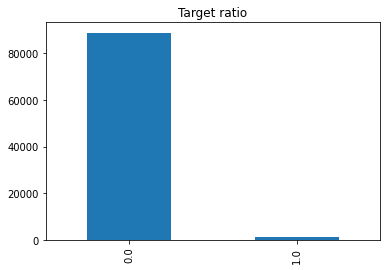

In [10]:
print(train.default.value_counts(normalize=True))
train.default.value_counts().plot.bar()
plt.title('Target ratio')

Dataset is imbalanced - there is skewness in target values.

## Exploratory analysis

Check some features and their impact on target.

In [11]:
def corr_plot(data, target_name):
    plt.figure(figsize=(16,4))
    data.corr()[target_name].sort_values(ascending = False).plot(kind='bar')
    plt.xticks(rotation=60)
    plt.show()
    
def corr_heatmap(data):
    correlations = data.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()

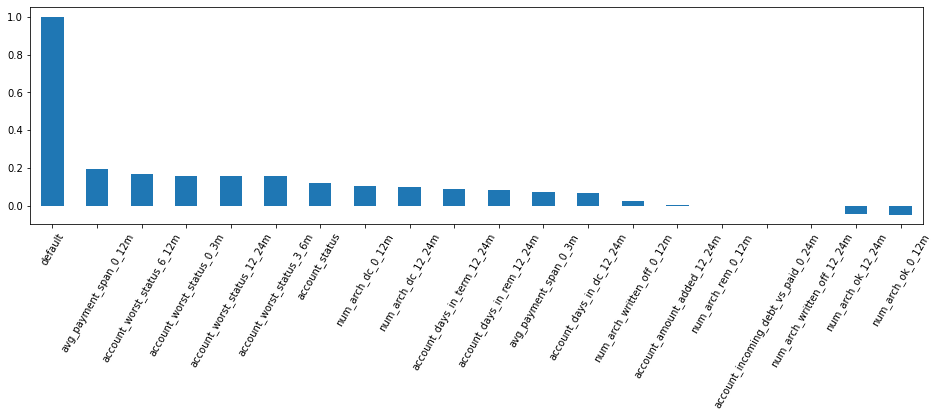

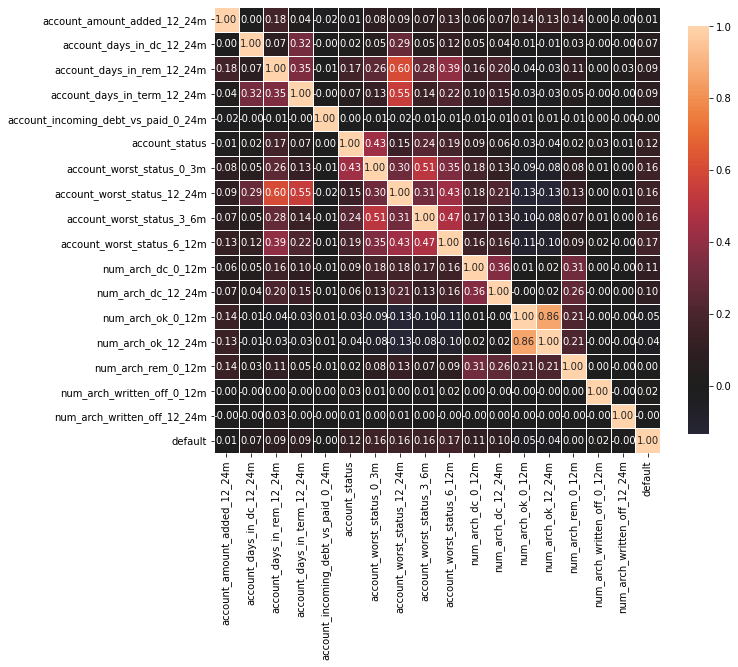

In [12]:
account_cols = [col for col in train.columns if col.startswith('account_')]
num_arch_cols = [col for col in train.columns if col.startswith('num_arch')]
avg_payment_cols = [col for col in train.columns if col.startswith('avg_payment')]

corr_plot(train[num_arch_cols+account_cols+avg_payment_cols+['default']], 'default')
corr_heatmap(train[account_cols+num_arch_cols+['default']])

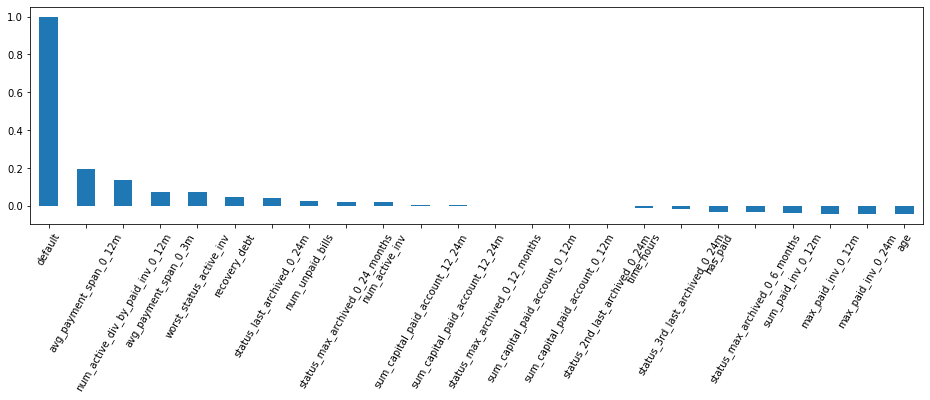

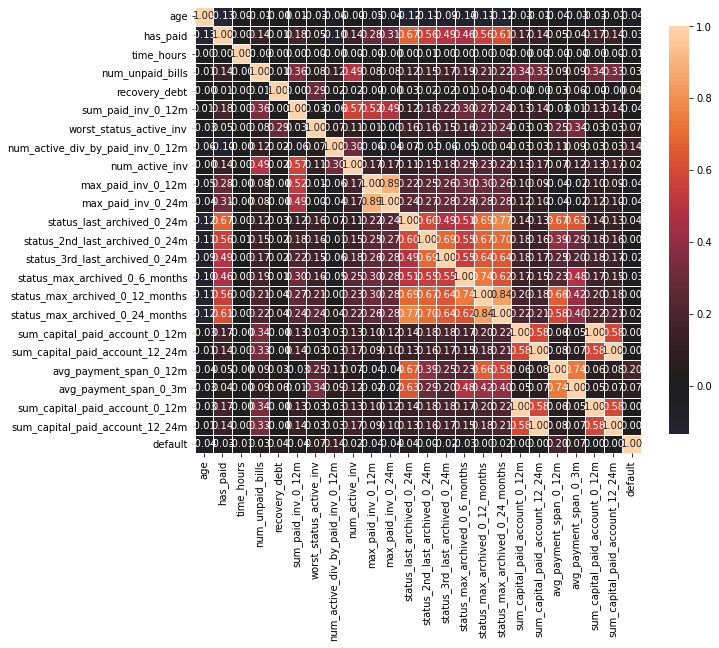

In [13]:
num_active_cols = [col for col in train.columns if col.startswith('num_active_')]
max_paid_cols = [col for col in train.columns if col.startswith('max_paid_')]
cols = ["age", "has_paid", "time_hours", "name_in_email", "num_unpaid_bills", "recovery_debt", "sum_paid_inv_0_12m", "worst_status_active_inv"]
status_cols = [col for col in train.columns if col.startswith('status_')]
sum_capital_cols = [col for col in train.columns if col.startswith('sum_capital')]
avg_payment_cols = [col for col in train.columns if col.startswith('avg_payment_')]
sum_capital_paid_cols = [col for col in train.columns if col.startswith('sum_capital_paid')]

corr_plot(data[cols+num_active_cols+max_paid_cols+status_cols+sum_capital_cols+avg_payment_cols+sum_capital_paid_cols+['default']], 'default')
corr_heatmap(train[cols+num_active_cols+max_paid_cols+status_cols+sum_capital_cols+avg_payment_cols+sum_capital_paid_cols+['default']])

- There are no significant correlations between features and the target value (the heightst corr value is 0.2 for avg_payment_span_0_12m);
- There is multicolinearity - some features are positive correlated with each other, which can be observed on the heatmaps.

## Feature engineering

In [14]:
train.dtypes

default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_div_by_paid_inv_0_12m       float64
num_active_in

In [15]:
train.describe()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
count,89976.000000,8.997600e+04,79293.000000,79293.000000,79293.000000,36619.000000,41042.000000,41042.000000,29921.000000,38038.000000,35663.000000,89976.000000,68508.000000,45594.000000,89976.000000,89976.000000,69318.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,73671.000000,73671.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,89976.000000,8.997600e+04,89976.000000,27436.000000
mean,0.014315,1.227615e+04,0.217333,5.073840,0.287894,1.330536,1.041665,1.173286,1.339227,1.185446,1.254045,36.019050,17.977933,14.960416,9224.090658,11244.316873,0.114667,0.598704,0.061761,0.059749,7.289777,6.380702,0.467258,0.000109,0.000136,2.142249,0.922791,0.827987,0.744499,0.800258,1.051547,1.225782,4.044401,10833.659832,6579.854317,3.921349e+04,15.336351,1.122503
std,0.118786,3.546356e+04,5.629972,22.957817,2.930697,26.924730,0.201766,0.420694,0.575655,0.442856,0.506764,12.999713,12.804216,10.259607,13576.947551,15257.546930,0.293679,1.544341,0.373620,0.368212,16.074663,15.397921,1.351350,0.010420,0.012762,6.296635,0.569607,0.622776,0.634204,0.719561,0.785793,0.833651,167.324157,26494.078628,19192.785345,8.940011e+04,5.030674,0.344673
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000278,1.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.000000,10.800000,8.400000,2000.000000,3340.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.630000e+03,11.629167,1.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.153818,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000,14.904762,13.000000,6055.000000,7585.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.600000e+04,15.800833,1.000000
75%,0.000000,4.984250e+03,0.000000,0.000000,0.000000,0.664694,1.000000,1.000000,2.000000,1.000000,1.000000,45.000000,21.040124,18.222222,11380.000000,13810.000000,0.100000,1.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9098.250000,100.000000,4.389925e+04,19.548056,1.000000
max,1.000000,1.128775e+06,362.000000,365.000000,97.000000,3914.000000,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000,260.000000,86.000000,279000.000000,279000.000000,9.000000,47.000000,16.000000,13.000000,261.000000,313.000000,42.000000,1.000000,2.000000,182.000000,5.000000,5.000000,5.000000,3.000000,5.000000,5.000000,36479.000000,571475.000000,341859.000000,2.962870e+06,23.999722,3.000000


In [16]:
categorical_low_card = [col for col in train.columns if col.find("status") != -1]
categorical_high_card = ["merchant_category", "merchant_group", "name_in_email"]
binary = ["has_paid"]
numerical = list(set(train.columns) - set(categorical_low_card + categorical_high_card + binary) - set(['default']))

### Check for outliers

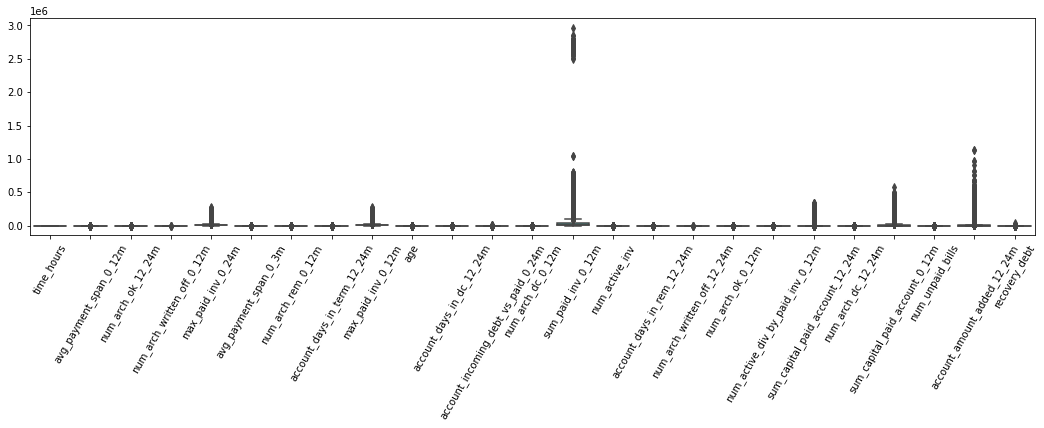

In [17]:
plt.figure(figsize=(18,4))
sns.boxplot(data=train[numerical])
plt.xticks(rotation=60)
plt.show()

In [18]:
# Detect and remove outliers with boxplot: 
def IQR_Outliers(df, cols):
    features_with_outliers = []
    for col in cols:
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        # Compute interquartile range. 
        IQR = Q3 - Q1
        cut_off = IQR * 1.5
        
        filter = (df[col] < Q1 - cut_off) | (df[col] > Q3 + cut_off)
        outliers = df.loc[filter].index.tolist()
        
        if len(outliers) > 0:
            print(f"outliers: {round(len(outliers) * 100 / df.shape[0], 2)}%   col: {col}")
numerical_features_with_outliers = IQR_Outliers(train, numerical)
categorical_features_with_outliers = IQR_Outliers(train, categorical_low_card)

outliers: 5.43%   col: avg_payment_span_0_12m
outliers: 10.09%   col: num_arch_ok_12_24m
outliers: 0.01%   col: num_arch_written_off_0_12m
outliers: 6.9%   col: max_paid_inv_0_24m
outliers: 3.36%   col: avg_payment_span_0_3m
outliers: 23.21%   col: num_arch_rem_0_12m
outliers: 1.22%   col: account_days_in_term_12_24m
outliers: 6.3%   col: max_paid_inv_0_12m
outliers: 0.44%   col: age
outliers: 0.26%   col: account_days_in_dc_12_24m
outliers: 3.6%   col: account_incoming_debt_vs_paid_0_24m
outliers: 4.25%   col: num_arch_dc_0_12m
outliers: 8.69%   col: sum_paid_inv_0_12m
outliers: 5.71%   col: num_active_inv
outliers: 9.69%   col: account_days_in_rem_12_24m
outliers: 0.01%   col: num_arch_written_off_12_24m
outliers: 9.9%   col: num_arch_ok_0_12m
outliers: 9.4%   col: num_active_div_by_paid_inv_0_12m
outliers: 24.82%   col: sum_capital_paid_account_12_24m
outliers: 4.01%   col: num_arch_dc_12_24m
outliers: 15.81%   col: sum_capital_paid_account_0_12m
outliers: 9.41%   col: num_unpaid_bi

## Building a model

The model base is implemented in `BaselineModel` class. To train and evaluate various models I'll define corresponding model configs and pass them along with the processed data. 
The tested models:

* Logistic Regression
* Random Forest
* Lightbgm

Before training a model there is a preprocessing step in the pipeline. It includes:

 * Imputer,
 * Target encoder for high-cardinality categorical features,
 * Outlier removal,
 * Scaler (which is needed for Logistic regreesion, but no needed for xgb or random forest)

In [19]:
# Create correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
to_drop

['avg_payment_span_0_3m',
 'max_paid_inv_0_24m',
 'num_arch_ok_12_24m',
 'status_max_archived_0_12_months',
 'status_max_archived_0_24_months',
 'sum_capital_paid_account_12_24m']

In [20]:
# set the model configs
log_reg_config_base = {
    "model_name": 'log-reg-base',
    "target_column": 'default',
    "categorical_high_card": categorical_high_card,
    "categorical_low_card": categorical_low_card,
    "numerical_features": numerical,
    "binary_features": binary,
    "classifier": LogisticRegression(class_weight="balanced"),
    "classifier_params" : {"clf__C": [10],
                           "clf__penalty":["l2"],
                           "proc__num__num_imputer__strategy": ["mean", "median"]
                          } 
}

log_reg_truncated_config = {
    "model_name": 'log-reg_truncated',
    "target_column": 'default',
    "categorical_high_card": categorical_high_card,
    "categorical_low_card": list(set(categorical_low_card) - set(to_drop)),
    "numerical_features": list(set(numerical) - set(to_drop)),
    "binary_features": binary,
    "classifier": LogisticRegression(class_weight="balanced"),
    "classifier_params" : {"clf__C": [10, 100],
                           "clf__penalty": ["l2"],
                           "proc__num__num_imputer__strategy": ["mean", "median"]
                          } 
}

random_frst_config = {
    "model_name": 'random_forest',
    "target_column": 'default',
    "categorical_high_card": categorical_high_card,
    "categorical_low_card": categorical_low_card,
    "numerical_features": numerical,
    "binary_features": binary,
    "classifier": RandomForestClassifier(n_jobs=-1),
    "classifier_params" : {"clf__n_estimators": [50, 100],
                           "clf__class_weight": ['balanced_subsample', 'balanced'],
                           "proc__num__num_imputer__strategy": ["mean", "median"]
    } 
}

xgb_config = {
    "model_name": 'lightgbm',
    "target_column": 'default',
    "categorical_high_card": categorical_high_card,
    "categorical_low_card": categorical_low_card,
    "numerical_features": numerical,
    "binary_features": binary,
    "classifier": LGBMClassifier(n_jobs=-1),
    "classifier_params" : {"clf__n_estimators": [10, 20, 50],
                           "clf__colsample_bytree": [0.6, 0.8, 1],
                           'clf__learning_rate': [0.02, 0.05, 0.07],
                           "proc__num__num_imputer__strategy":["mean", "median"]
    } 
}

In [21]:
# train models
log_regression = BaselineModel(log_reg_config_base)
log_reg_base_model = log_regression.train_model(train)

log_regression = BaselineModel(log_reg_truncated_config)
log_reg_trunc_model = log_regression.train_model(train)

random_forest = BaselineModel(random_frst_config)
random_forest_model = random_forest.train_model(train)

xgb = BaselineModel(xgb_config)
xgb_model = xgb.train_model(train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=mean;, score=0.806 total time=   0.6s
[CV 2/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=mean;, score=0.799 total time=   0.6s
[CV 3/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=mean;, score=nan total time=   0.6s
[CV 1/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=median;, score=0.808 total time=   0.7s
[CV 2/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=median;, score=0.799 total time=   0.7s
[CV 3/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=median;, score=nan total time=   0.7s
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=mean;, score=0.806 total time=   0.6s
[CV 2/3] END clf__C=10, clf__penalty=l2, proc__num__num_imputer__strategy=mean;, score=0.798 to

[CV 3/3] END clf__colsample_bytree=0.6, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.6s
[CV 1/3] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.4s
[CV 2/3] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.4s
[CV 3/3] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.4s
[CV 1/3] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.5s
[CV 2/3] END clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.5s
[CV 3/3] END clf__colsample_bytree=0.6, clf__l

[CV 1/3] END clf__colsample_bytree=0.8, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.6s
[CV 2/3] END clf__colsample_bytree=0.8, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.6s
[CV 3/3] END clf__colsample_bytree=0.8, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.7s
[CV 1/3] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.5s
[CV 2/3] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.6s
[CV 3/3] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.6s
[CV 1/3] END clf__colsample_bytree=0.8, clf__l

[CV 2/3] END clf__colsample_bytree=1, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.6s
[CV 3/3] END clf__colsample_bytree=1, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.5s
[CV 1/3] END clf__colsample_bytree=1, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.986 total time=   0.6s
[CV 2/3] END clf__colsample_bytree=1, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.6s
[CV 3/3] END clf__colsample_bytree=1, clf__learning_rate=0.02, clf__n_estimators=50, proc__num__num_imputer__strategy=median;, score=0.985 total time=   0.6s
[CV 1/3] END clf__colsample_bytree=1, clf__learning_rate=0.05, clf__n_estimators=10, proc__num__num_imputer__strategy=mean;, score=0.985 total time=   0.4s
[CV 2/3] END clf__colsample_bytree=1, clf__learning_rate=0

## Model evaluation
### Evaluation metrics

Since we have imbalanced target variable, the metrics for evaluation should be selected accordingly.
For the evaluation and comparison we can use following metrics:
    
* F1 score
* Precision recall curve
* Avg precision score - is a numeric representation of precision recall curve
* ROC AUC score

### Models comparison

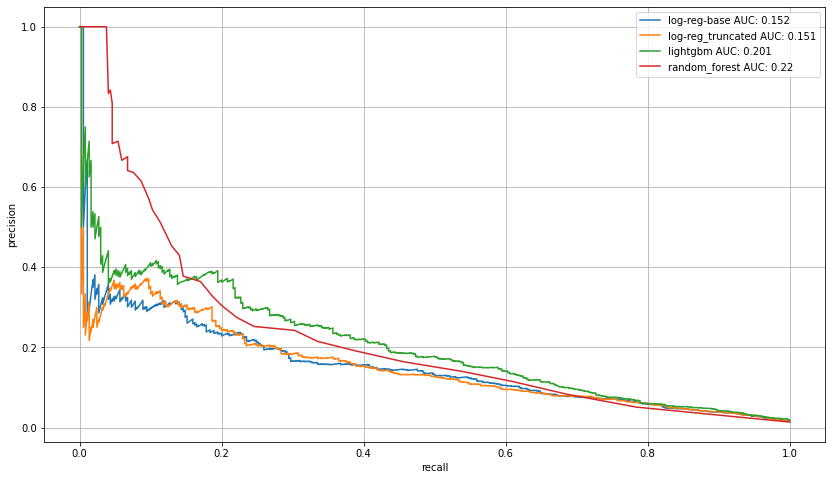

In [22]:
# Plot precision - recall curves for every model and compare them
plt.rcParams["figure.figsize"] = (14, 8)

plt.plot(log_reg_base_model['model_metrics']['recall'], 
         log_reg_base_model['model_metrics']['precision'],
         label=f"{log_reg_base_model['model_name']} AUC: {log_reg_base_model['model_metrics']['pr_curve_auc']}"
        )

plt.plot(log_reg_trunc_model['model_metrics']['recall'], 
         log_reg_trunc_model['model_metrics']['precision'],
         label=f"{log_reg_trunc_model['model_name']} AUC: {log_reg_trunc_model['model_metrics']['pr_curve_auc']}"
        )

plt.plot(xgb_model['model_metrics']['recall'], 
        xgb_model['model_metrics']['precision'],
        label=f"{xgb_model['model_name']} AUC: {xgb_model['model_metrics']['pr_curve_auc']}"
       )

plt.plot(random_forest_model['model_metrics']['recall'], 
         random_forest_model['model_metrics']['precision'],
         label=f"{random_forest_model['model_name']} AUC: {random_forest_model['model_metrics']['pr_curve_auc']}"
        )

plt.legend()
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

In [23]:
def create_report(model_config):
    """Parse metrics and return dataframe"""
    report_df = pd.DataFrame.from_dict(model_config['model_metrics'], 
                                       orient='index', 
                                       columns=[model_config['model_name']])
    return report_df.loc[['f1_score', 
                          'avg_precision_score', 
                          'roc_auc_score']]

create_report(log_reg_base_model).join(create_report(log_reg_trunc_model))\
                                 .join(create_report(random_forest_model))\
                                 .join(create_report(xgb_model))

,log-reg-base,log-reg_truncated,random_forest,lightgbm
f1_score,0.101013,0.103407,0.0862944,0.0514139
avg_precision_score,0.152945,0.152212,0.206322,0.202869
roc_auc_score,0.88975,0.888463,0.836401,0.904859


## Feature Importance
At the final step we examine what features are important. 
On the example of random forest model we can see that:

- *age* and *avg_payment_span_0_12m* are significantly important features.
- There are Top-5 features of the highest importance and the importance of the rest features is slightly decreasing. It might be a good idea to remove the Top-5 features and train the model again in order to find what features might play a role besides leaders.
- *merchant_category* is categorical feature with high cardinality encoded with Target encoder plays a great role.

In [24]:
features_for_importance = random_forest_model['model']['proc'].transformers_[0][2] + \
                          random_forest_model['model']['proc'].transformers_[1][2] + \
                          random_forest_model['model']['proc'].transformers_[2][2] + \
                          random_forest_model['model']['proc'].transformers_[3][2]

In [25]:
forest_importances = pd.DataFrame(zip(features_for_importance, random_forest_model['model']['clf'].feature_importances_),
             columns=['feature', 'importance']).sort_values('importance', ascending=True).set_index('feature')


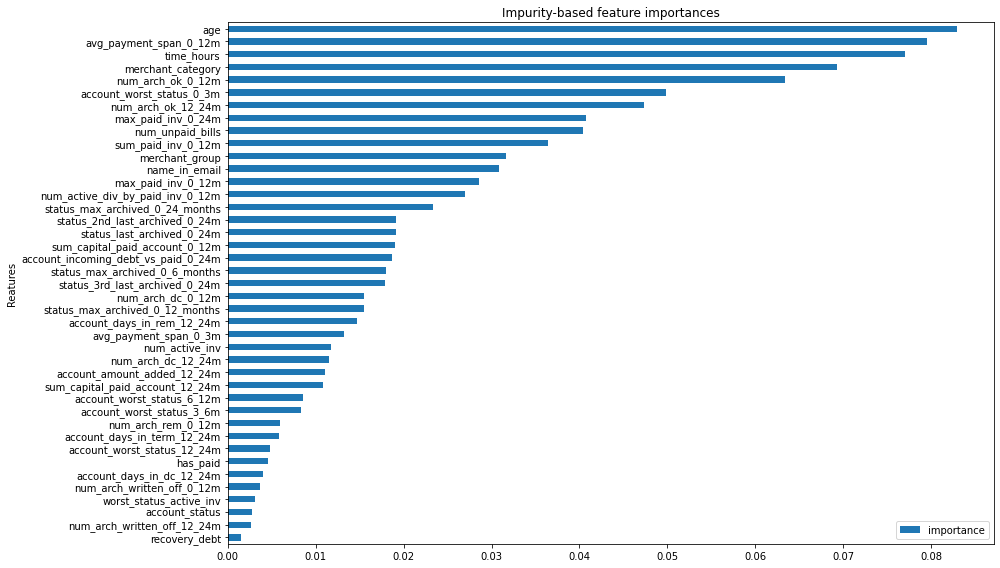

In [26]:
fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Impurity-based feature importances")
ax.set_ylabel("Reatures")
fig.tight_layout()

## Make predictions

In [28]:
y_probs = random_forest_model['model'].predict_proba(test)[:, 1]

submission = pd.DataFrame({"uuid" : test.index, "pd" : y_probs})
submission.to_csv("data/submission.csv", sep = ";", index=False)

## Save model

In [ ]:
import pickle
pickle.dump(random_forest_model['model'], open("pickled_model.pickle", "wb"))

# Conclusion
- Both Logistic Regressions showed poor performance in `avg_precision_score` and lower `precision-recall curve` compared to tree-based models.
- Tree-based models demonstrated lower `f1_score` but gained in `avg_precision_score` which is essential in imbalanced problems.
- Random forest outperforms xgb model by the total area under `precision-recall curve`.
- The top-5 important features based on impurity include standardized numerical features and categorical with target encoding. 